<a href="https://colab.research.google.com/github/janchorowski/nn_assignments/blob/nn18/assignment4/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starter code: network for Irises in Pytorch


In the following cells a feedforward neural network has been implemented with the aid of PyTorch and its autograd mechanism. Please study the code - many network implementations follow a similar pattern.

The provided network trains to nearly 100% accuracy on Iris using Batch Gradient Descent.

# Assignment 4

**Submission deadline:** 

**problems 1-2 last lab session before or on Wednesday, 30.11.18**

**problems 3-8 last lab session before or on Wednesday, 7.12.18**


**Points: 11 + 5 bonus points**


## Downloading this notebook

This assignment is an Colab/Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

If you use Colab please make sure to have a GPU runtime (```Runtime -> Change runtime type -> Hardware Accelarater = GPU```)

In [1]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
#!pip install -q gdown httpimport
#![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz
#![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

import httpimport
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from sklearn import datasets

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

sns.set_style('whitegrid')

torch-0.4.1-cp27-cp27mu-linux_x86_64.whl is not a supported wheel on this platform.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Getting to know PyTorch

From now on, we will use [pytorch](https://pytorch.org/) to implement neural networks.

Good introductions are the [60-minute tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and [pytorch examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).


Pytorch has a set of modules to build neural networks. However, for simplicity, this assignment will use a custom, simple neural network code.

In [3]:
import numpy as np
import time
import torch
import torch.nn.functional as F


class Layer(object):
    
    def train_mode(self):
        """Put layer into training mode.
        
        This is useful for e.g. Dropout.
        """
        pass
    
    def eval_mode(self):
        """Put layer into evalation mode.
        
        This is useful for e.g. Dropout.
        """
        pass
    
    def to_device(self, device):
        """Move this layer's parameters to thie given device (cpu/cuda).
        """
        
        pass
    
    @property
    def parameters(self):
        return []
    
    def __repr__(self):
        param_s = ', '.join(['%s%s' % (n, tuple(p.size())) 
                                 for (n,p) in self.parameters])
        if not param_s:
            return '  %s with no params' % (self.__class__.__name__)
        else:
            return '  %s with params: %s' % (self.__class__.__name__, param_s)
    

class AffineLayer(Layer):
    def __init__(self, num_in, num_out):
        self.W = torch.empty(num_in, num_out, dtype=torch.float32, requires_grad=True)
        self.b = torch.empty(1, num_out, dtype=torch.float32, requires_grad=True)
    
    @property
    def parameters(self):
        return [('W', self.W), ('b', self.b)]
    
    def forward(self, x):
        return x.mm(self.W) + self.b
    
    def to_device(self, device):
        with torch.no_grad():
            self.W = self.W.to(device).requires_grad_()
            self.b = self.b.to(device).requires_grad_()

    
class TanhLayer(Layer):
    def forward(self, x):
        return F.tanh(x)

    
class  ReLULayer(Layer):
    def forward(self, x):
        return F.relu(x)


class SoftMaxLayer(Layer):
    def forward(self, x):
        return F.softmax(x, dim=-1)

class CrossEntropyLoss:
    def forward(self, probs, targets):
        return torch.mean(-torch.log(torch.gather(
            probs, 1, targets.unsqueeze(1))))
    
class DropoutLayer(Layer):
    def __init__(self, p):
        self.train = True
        self.p = p
        
    def train_mode(self):
        self.train = True
    
    def eval_mode(self):
        self.train = False
    
    def forward(self, x):
        return F.dropout(x, p=self.p, training=self.train)

In [4]:
class FeedforwardNet(object):
    def __init__(self, layers):
        self.layers = layers
        self.loss_fn = CrossEntropyLoss()

    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params

    @parameters.setter
    def parameters(self, values):
        for (_, ownP), newP in zip(self.parameters, values):
            ownP.data = newP.data
    
    def to_device(self, device):
        for layer in self.layers:
            layer.to_device(device)
    
    def train_mode(self):
        for layer in self.layers:
            layer.train_mode()
    
    def eval_mode(self):
        for layer in self.layers:
            layer.eval_mode()    
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def loss(self, outputs, targets):
        return self.loss_fn.forward(outputs, targets)
    
    def __repr__(self):
        strs = ["Feedorward network with %d layers:" % (len(self.layers),)]
        for layer in self.layers:
            strs.append(repr(layer))
        return '\n'.join(strs)
            

In [4]:
from sklearn import datasets

iris = datasets.load_iris()
IrisX = iris.data.astype(np.float32)
IrisX = (IrisX - IrisX.mean(axis=0, keepdims=True)) / IrisX.std(axis=0, keepdims=True)
IrisY = iris.target

IrisX = torch.from_numpy(IrisX)
IrisY = torch.from_numpy(IrisY)
print IrisX.shape

torch.Size([150, 4])


In [107]:
def GD(model, x, y, alpha=1e-4, max_iters=1000000, tolerance=1e-6, device='cpu'):
    """Simple batch gradient descent"""
    x = x.to(device)
    y = y.to(device)
    model.to_device(device)
    try:
        old_loss = np.inf
        model.train_mode()
        tstart = time.time()
        for i in xrange(max_iters):
            outputs = model.forward(x)
            loss = model.loss(outputs, y)

            loss.backward()
            
            # this disables autograd mechanism and allows us to 
            with torch.torch.no_grad():
                for _, p in model.parameters:
                    p -= p.grad * alpha
                    # Zero gradients for the next iteration
                    p.grad.zero_()

            loss = loss.item()
            if old_loss < loss:
                print "Iter: %d, loss increased!" % (i,)
            if (old_loss - loss) < tolerance:
                print "Tolerance level reached. Exiting."
                break
            if i % 1000 == 0:
                _, predictions = outputs.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / outputs.size(0)
                print "Iteration {0: >6} | loss {1: >5.2f} | err rate  {2: >5.2f}% | steps/s {3: >5.2f}" \
                      .format(i, loss, err_rate, (1000 if i else 1) / (time.time() - tstart))
                tstart = time.time()
            old_loss = loss
    except KeyboardInterrupt:
        pass

In [8]:
model = FeedforwardNet(
    [AffineLayer(4, 10),
     TanhLayer(),
     AffineLayer(10, 3),
     SoftMaxLayer(),
    ])


# Initialize parameters
with torch.torch.no_grad():
    for n, p in model.parameters:
        if n == 'W':
            # p.data.normal_(0, 0.05)
            p.uniform_(-0.1, 0.1)
        elif n == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# Train
# Iris is so small, that trainingon CPU is faster!
GD(model, IrisX, IrisY, alpha=1e-1, tolerance=1e-7, device='cpu')

/usr/lib/python2.7/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration      0 | loss  1.11 | err rate  98.00% | steps/s 225.28
Iteration   1000 | loss  0.05 | err rate   2.00% | steps/s 2425.04
Iteration   2000 | loss  0.04 | err rate   2.00% | steps/s 3017.95
Iteration   3000 | loss  0.04 | err rate   1.00% | steps/s 1449.72
Iteration   4000 | loss  0.04 | err rate   1.00% | steps/s 2115.10
Iteration   5000 | loss  0.04 | err rate   1.00% | steps/s 2332.28
Iteration   6000 | loss  0.04 | err rate   1.00% | steps/s 2330.93
Iteration   7000 | loss  0.04 | err rate   1.00% | steps/s 2580.83
Iteration   8000 | loss  0.04 | err rate   1.00% | steps/s 2838.63
Iteration   9000 | loss  0.04 | err rate   1.00% | steps/s 2717.91
Iteration  10000 | loss  0.04 | err rate   1.00% | steps/s 2623.91
Iteration  11000 | loss  0.04 | err rate   1.00% | steps/s 2905.12
Iteration  12000 | loss  0.04 | err rate   1.00% | steps/s 2488.07
Iteration  13000 | loss  0.04 | err rate   1.00% | steps/s 2670.33
Iteration  14000 | loss  0.04 | err rate   1.00% | steps/s 2645

# Starter code for MNIST and SGD scaffolding

In [7]:
import os
import torch
import torchvision


batch_size = 128
data_path = './data'

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)

_train.train_data = _train.train_data[:50000]
_train.train_labels = _train.train_labels[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_valid.train_data = _valid.train_data[50000:]
_valid.train_labels = _valid.train_labels[50000:]

mnist_loaders = {
    'train': torch.utils.data.DataLoader(
        _train, batch_size=batch_size, shuffle=True,
        pin_memory=True, num_workers=10),
    'valid': torch.utils.data.DataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(
        _test, batch_size=batch_size, shuffle=False)}


# Problem 1: Stochastic Gradient Descent [3p]
Implement the following additions to the SGD code provided below (in task 2):
  1. **[1p]** momentum
  2. **[1p]** learning rate schedule
  3. **[1p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use function `model.parameters` and select all parameters whose names are "`W`" and not "`b`".

# Problem 2: Tuning the Network for MNIST [4p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


In [6]:
def compute_error_rate(model, data_loader, device='cpu'):
    model.eval_mode()
    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device).view(x.size(0), -1)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples

def SGD(model, data_loaders, alpha=1e-4, num_epochs=1, patience_expansion=1.5,
        log_every=100, device='cpu', alpha_mult=0.05, epsilon=0.9):
    model.to_device(device)
    
    def alpha_adjust(i, alpha):
        if (i % 2000) == 0:
            return alpha - (alpha * alpha_mult)
        return alpha    
    
    #
    # TODO: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [torch.zeros(l[1].shape[0], l[1].shape[1]) for l in model.parameters]
    if device == 'cuda':
        velocities = [torch.cuda(f) for f in velocities]
    iter_ = 0
    epoch = 0
    reg_param = 0.001
    
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    print('Training the model!')
    print('Interrupt at any time to evaluate the best validation model so far.')
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train_mode()
            epoch += 1
            for x, y in data_loaders['train']:
                x = x.to(device).view(x.size(0), -1)
                y = y.to(device)
                iter_ += 1
                out = model.forward(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum().item() / out.size(0)

                history['train_losses'].append(loss.item())
                history['train_errs'].append(err_rate)
                
                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                
                
                # TODO: Update learning rate
                # Hint: Use the iteration counter i
                alpha = alpha_adjust(iter_, alpha)             
                
                with torch.no_grad():
                    for (name, p), v in zip(model.parameters, velocities):
                        if name == 'W':
                            #
                            # TODO: Implement weight decay addition to gradients
                            p.grad += reg_param * p
                            #

                        #
                        # TODO: Set the momentum constant 
                        #epsilon = 0.5
                        #
                        
                        #
                        # TODO: Implement velocity update in momentum
                        # lease make sure to modify the contents of v, not the v pointer!!!
                        v[...] = epsilon * v + p.grad
                        #
                        # TODO: Set a more sensible learning rule here,
                        #       using your learning rate schedule and momentum
                        # 
                        #
                        p -= alpha * v
                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}" \
                          .format(iter_, loss.item(), err_rate, num_iter / (time.time() - tstart))
                    tstart = time.time()
                           
            
            val_err_rate = compute_error_rate(model, data_loaders['valid'], device)
            history['val_errs'].append((iter_, val_err_rate))
            
            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for (_, p) in model.parameters]
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs | alpha {3:f}" \
                .format(epoch, val_err_rate, num_epochs, alpha)
            print '{0}\n{1}\n{0}'.format('-' * len(m), m)

    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print "\nLoading best params on validation set (epoch %d)\n" %(best_epoch)
        model.parameters = best_params
    plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.39 | err rate  9.38%, steps/s 35.91
Minibatch    200  | loss  0.26 | err rate  5.47%, steps/s 127.57
Minibatch    300  | loss  0.45 | err rate 14.06%, steps/s 168.42
---------------------------------------------------------------------------
After epoch  1 | valid err rate:  4.91% | doing   2 epochs | alpha 0.100000
---------------------------------------------------------------------------
Minibatch    400  | loss  0.23 | err rate  6.25%, steps/s 125.82
Minibatch    500  | loss  0.14 | err rate  6.25%, steps/s 231.32
Minibatch    600  | loss  0.09 | err rate  2.34%, steps/s 202.74
Minibatch    700  | loss  0.11 | err rate  3.91%, steps/s 298.70
---------------------------------------------------------------------------
After epoch  2 | valid err rate:  3.75% | doing   4 epochs | alpha 0.100000
---------------------------------------------------------------------------
Mi

Minibatch   6700  | loss  0.02 | err rate  0.00%, steps/s 2592.52
Minibatch   6800  | loss  0.04 | err rate  0.78%, steps/s 4938.10
Minibatch   6900  | loss  0.03 | err rate  0.78%, steps/s 4725.26
Minibatch   7000  | loss  0.04 | err rate  0.00%, steps/s 4056.90
---------------------------------------------------------------------------
After epoch 18 | valid err rate:  2.05% | doing  28 epochs | alpha 0.068147
---------------------------------------------------------------------------
Minibatch   7100  | loss  0.02 | err rate  0.00%, steps/s 2482.35
Minibatch   7200  | loss  0.03 | err rate  0.78%, steps/s 3931.00
Minibatch   7300  | loss  0.03 | err rate  0.00%, steps/s 4961.37
Minibatch   7400  | loss  0.03 | err rate  0.78%, steps/s 4982.23
---------------------------------------------------------------------------
After epoch 19 | valid err rate:  2.03% | doing  29 epochs | alpha 0.068147
---------------------------------------------------------------------------
Minibatch   7500

Minibatch  13300  | loss  0.03 | err rate  0.00%, steps/s 4662.30
Minibatch  13400  | loss  0.05 | err rate  1.56%, steps/s 9587.19
Minibatch  13500  | loss  0.02 | err rate  0.00%, steps/s 8785.43
Minibatch  13600  | loss  0.02 | err rate  0.00%, steps/s 8418.56
---------------------------------------------------------------------------
After epoch 35 | valid err rate:  2.04% | doing  50 epochs | alpha 0.046440
---------------------------------------------------------------------------
Minibatch  13700  | loss  0.03 | err rate  0.78%, steps/s 4630.67
Minibatch  13800  | loss  0.02 | err rate  0.00%, steps/s 8304.07
Minibatch  13900  | loss  0.02 | err rate  0.00%, steps/s 7271.33
Minibatch  14000  | loss  0.02 | err rate  0.00%, steps/s 7492.82
---------------------------------------------------------------------------
After epoch 36 | valid err rate:  1.94% | doing  50 epochs | alpha 0.040868
---------------------------------------------------------------------------
Minibatch  14100

Minibatch  20000  | loss  0.02 | err rate  0.00%, steps/s 6364.06
Minibatch  20100  | loss  0.03 | err rate  0.78%, steps/s 13918.47
Minibatch  20200  | loss  0.03 | err rate  0.78%, steps/s 9415.99
Minibatch  20300  | loss  0.01 | err rate  0.00%, steps/s 11595.16
---------------------------------------------------------------------------
After epoch 52 | valid err rate:  1.90% | doing  68 epochs | alpha 0.027850
---------------------------------------------------------------------------
Minibatch  20400  | loss  0.03 | err rate  0.00%, steps/s 6269.57
Minibatch  20500  | loss  0.02 | err rate  0.78%, steps/s 13244.72
Minibatch  20600  | loss  0.01 | err rate  0.00%, steps/s 7435.58
Minibatch  20700  | loss  0.04 | err rate  0.78%, steps/s 7167.37
---------------------------------------------------------------------------
After epoch 53 | valid err rate:  1.87% | doing  68 epochs | alpha 0.027850
---------------------------------------------------------------------------
Minibatch  20

Minibatch  26600  | loss  0.02 | err rate  0.00%, steps/s 6059.80
Minibatch  26700  | loss  0.02 | err rate  0.00%, steps/s 13776.18
Minibatch  26800  | loss  0.03 | err rate  0.00%, steps/s 17928.38
Minibatch  26900  | loss  0.03 | err rate  0.00%, steps/s 19881.50
---------------------------------------------------------------------------
After epoch 69 | valid err rate:  1.89% | doing  86 epochs | alpha 0.018979
---------------------------------------------------------------------------
Minibatch  27000  | loss  0.01 | err rate  0.00%, steps/s 8317.20
Minibatch  27100  | loss  0.03 | err rate  0.78%, steps/s 19902.30
Minibatch  27200  | loss  0.04 | err rate  0.78%, steps/s 14187.65
Minibatch  27300  | loss  0.03 | err rate  0.00%, steps/s 18357.30
---------------------------------------------------------------------------
After epoch 70 | valid err rate:  1.78% | doing 106 epochs | alpha 0.018979
---------------------------------------------------------------------------
Minibatch 

Minibatch  33300  | loss  0.02 | err rate  0.00%, steps/s 13417.46
Minibatch  33400  | loss  0.01 | err rate  0.00%, steps/s 25991.12
Minibatch  33500  | loss  0.03 | err rate  0.00%, steps/s 25420.20
Minibatch  33600  | loss  0.03 | err rate  0.78%, steps/s 24513.46
---------------------------------------------------------------------------
After epoch 86 | valid err rate:  1.79% | doing 106 epochs | alpha 0.012934
---------------------------------------------------------------------------
Minibatch  33700  | loss  0.01 | err rate  0.00%, steps/s 13614.89
Minibatch  33800  | loss  0.03 | err rate  0.00%, steps/s 25748.94
Minibatch  33900  | loss  0.06 | err rate  0.78%, steps/s 25807.88
Minibatch  34000  | loss  0.02 | err rate  0.00%, steps/s 22875.06
---------------------------------------------------------------------------
After epoch 87 | valid err rate:  1.81% | doing 106 epochs | alpha 0.011382
---------------------------------------------------------------------------
Minibatc

Minibatch  39900  | loss  0.03 | err rate  0.00%, steps/s 14756.77
Minibatch  40000  | loss  0.03 | err rate  0.00%, steps/s 29254.10
Minibatch  40100  | loss  0.02 | err rate  0.00%, steps/s 29279.10
Minibatch  40200  | loss  0.02 | err rate  0.00%, steps/s 28785.11
----------------------------------------------------------------------------
After epoch 103 | valid err rate:  1.79% | doing 152 epochs | alpha 0.007756
----------------------------------------------------------------------------
Minibatch  40300  | loss  0.02 | err rate  0.00%, steps/s 15113.60
Minibatch  40400  | loss  0.03 | err rate  0.00%, steps/s 29857.58
Minibatch  40500  | loss  0.03 | err rate  0.00%, steps/s 29689.62
Minibatch  40600  | loss  0.02 | err rate  0.00%, steps/s 27788.42
----------------------------------------------------------------------------
After epoch 104 | valid err rate:  1.82% | doing 152 epochs | alpha 0.007756
----------------------------------------------------------------------------
Mi

Minibatch  46600  | loss  0.03 | err rate  0.00%, steps/s 13527.05
Minibatch  46700  | loss  0.03 | err rate  0.78%, steps/s 20443.86
Minibatch  46800  | loss  0.03 | err rate  0.78%, steps/s 32118.40
Minibatch  46900  | loss  0.02 | err rate  0.00%, steps/s 31925.66
----------------------------------------------------------------------------
After epoch 120 | valid err rate:  1.82% | doing 152 epochs | alpha 0.005286
----------------------------------------------------------------------------
Minibatch  47000  | loss  0.02 | err rate  0.00%, steps/s 12598.10
Minibatch  47100  | loss  0.03 | err rate  0.78%, steps/s 29664.50
Minibatch  47200  | loss  0.01 | err rate  0.00%, steps/s 33155.29
Minibatch  47300  | loss  0.02 | err rate  0.78%, steps/s 33481.94
----------------------------------------------------------------------------
After epoch 121 | valid err rate:  1.79% | doing 152 epochs | alpha 0.005286
----------------------------------------------------------------------------
Mi

Minibatch  53200  | loss  0.02 | err rate  0.00%, steps/s 18513.35
Minibatch  53300  | loss  0.02 | err rate  0.00%, steps/s 27956.59
Minibatch  53400  | loss  0.02 | err rate  0.00%, steps/s 39677.95
Minibatch  53500  | loss  0.03 | err rate  0.00%, steps/s 37119.27
----------------------------------------------------------------------------
After epoch 137 | valid err rate:  1.81% | doing 152 epochs | alpha 0.003602
----------------------------------------------------------------------------
Minibatch  53600  | loss  0.03 | err rate  0.78%, steps/s 20092.90
Minibatch  53700  | loss  0.02 | err rate  0.78%, steps/s 41334.12
Minibatch  53800  | loss  0.01 | err rate  0.00%, steps/s 41307.92
Minibatch  53900  | loss  0.03 | err rate  0.00%, steps/s 40586.88
----------------------------------------------------------------------------
After epoch 138 | valid err rate:  1.79% | doing 152 epochs | alpha 0.003602
----------------------------------------------------------------------------
Mi

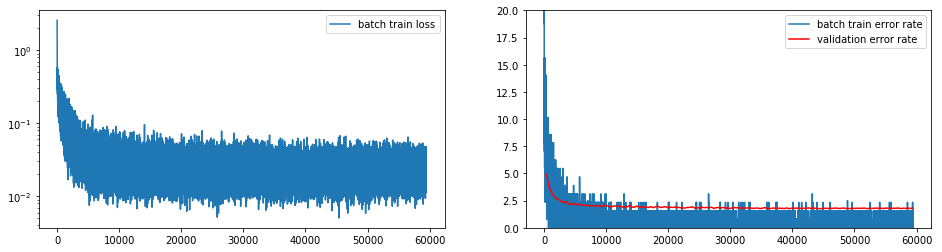

In [137]:
model = FeedforwardNet(
    [
     AffineLayer(784, 500),
     TanhLayer(),
     AffineLayer(500,10),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            p.normal_(0, 0.05)
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, device='cpu')

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

# Problem 3: Dropout [2p]

Implement a **dropout** layer and try to train a
network getting below 1.5% test error rates with dropout. The best
results with dropout are below 1%!

Remember to turn off dropout during testing, using `model.train_mode()` and `model.eval_mode()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.49 | err rate 10.94%, steps/s 24.28
Minibatch    200  | loss  0.40 | err rate 14.84%, steps/s 50.49
Minibatch    300  | loss  0.43 | err rate 14.06%, steps/s 55.63
---------------------------------------------------------------------------
After epoch  1 | valid err rate:  4.59% | doing   2 epochs | alpha 0.100000
---------------------------------------------------------------------------
Minibatch    400  | loss  0.21 | err rate  7.03%, steps/s 52.81
Minibatch    500  | loss  0.26 | err rate 11.72%, steps/s 93.04
Minibatch    600  | loss  0.26 | err rate  9.38%, steps/s 109.83
Minibatch    700  | loss  0.27 | err rate  7.81%, steps/s 124.98
---------------------------------------------------------------------------
After epoch  2 | valid err rate:  3.39% | doing   4 epochs | alpha 0.100000
---------------------------------------------------------------------------
Miniba

Minibatch   6700  | loss  0.03 | err rate  0.78%, steps/s 1339.42
Minibatch   6800  | loss  0.06 | err rate  1.56%, steps/s 1911.84
Minibatch   6900  | loss  0.03 | err rate  1.56%, steps/s 1871.98
Minibatch   7000  | loss  0.03 | err rate  1.56%, steps/s 1966.75
---------------------------------------------------------------------------
After epoch 18 | valid err rate:  1.72% | doing  26 epochs | alpha 0.096443
---------------------------------------------------------------------------
Minibatch   7100  | loss  0.07 | err rate  0.78%, steps/s 1422.51
Minibatch   7200  | loss  0.09 | err rate  1.56%, steps/s 2100.26
Minibatch   7300  | loss  0.03 | err rate  0.78%, steps/s 2104.14
Minibatch   7400  | loss  0.09 | err rate  2.34%, steps/s 2095.37
---------------------------------------------------------------------------
After epoch 19 | valid err rate:  1.79% | doing  26 epochs | alpha 0.096443
---------------------------------------------------------------------------
Minibatch   7500

Minibatch  13300  | loss  0.04 | err rate  1.56%, steps/s 2578.53
Minibatch  13400  | loss  0.03 | err rate  0.78%, steps/s 3736.55
Minibatch  13500  | loss  0.03 | err rate  0.78%, steps/s 3660.09
Minibatch  13600  | loss  0.09 | err rate  3.91%, steps/s 3869.93
---------------------------------------------------------------------------
After epoch 35 | valid err rate:  1.67% | doing  47 epochs | alpha 0.093013
---------------------------------------------------------------------------
Minibatch  13700  | loss  0.04 | err rate  2.34%, steps/s 2634.36
Minibatch  13800  | loss  0.07 | err rate  2.34%, steps/s 3950.37
Minibatch  13900  | loss  0.05 | err rate  2.34%, steps/s 3887.77
Minibatch  14000  | loss  0.05 | err rate  2.34%, steps/s 3815.47
---------------------------------------------------------------------------
After epoch 36 | valid err rate:  1.80% | doing  47 epochs | alpha 0.091896
---------------------------------------------------------------------------
Minibatch  14100

Minibatch  20000  | loss  0.08 | err rate  2.34%, steps/s 1820.75
Minibatch  20100  | loss  0.06 | err rate  0.78%, steps/s 3284.26
Minibatch  20200  | loss  0.06 | err rate  3.12%, steps/s 3222.65
Minibatch  20300  | loss  0.06 | err rate  1.56%, steps/s 2587.63
---------------------------------------------------------------------------
After epoch 52 | valid err rate:  1.66% | doing  62 epochs | alpha 0.088628
---------------------------------------------------------------------------
Minibatch  20400  | loss  0.03 | err rate  0.78%, steps/s 2150.86
Minibatch  20500  | loss  0.07 | err rate  3.12%, steps/s 3277.97
Minibatch  20600  | loss  0.03 | err rate  0.78%, steps/s 4291.70
Minibatch  20700  | loss  0.06 | err rate  2.34%, steps/s 2942.51
---------------------------------------------------------------------------
After epoch 53 | valid err rate:  1.65% | doing  62 epochs | alpha 0.088628
---------------------------------------------------------------------------
Minibatch  20800

Minibatch  26600  | loss  0.03 | err rate  0.00%, steps/s 5116.86
Minibatch  26700  | loss  0.03 | err rate  0.78%, steps/s 7568.50
Minibatch  26800  | loss  0.01 | err rate  0.00%, steps/s 7513.59
Minibatch  26900  | loss  0.02 | err rate  0.78%, steps/s 7117.11
---------------------------------------------------------------------------
After epoch 69 | valid err rate:  1.63% | doing  83 epochs | alpha 0.085475
---------------------------------------------------------------------------
Minibatch  27000  | loss  0.05 | err rate  2.34%, steps/s 5424.81
Minibatch  27100  | loss  0.06 | err rate  2.34%, steps/s 7808.31
Minibatch  27200  | loss  0.02 | err rate  0.00%, steps/s 7775.62
Minibatch  27300  | loss  0.03 | err rate  0.78%, steps/s 7695.05
---------------------------------------------------------------------------
After epoch 70 | valid err rate:  1.41% | doing 106 epochs | alpha 0.085475
---------------------------------------------------------------------------
Minibatch  27400

Minibatch  33300  | loss  0.05 | err rate  1.56%, steps/s 6383.12
Minibatch  33400  | loss  0.01 | err rate  0.00%, steps/s 9511.84
Minibatch  33500  | loss  0.04 | err rate  1.56%, steps/s 9550.19
Minibatch  33600  | loss  0.06 | err rate  2.34%, steps/s 9446.01
---------------------------------------------------------------------------
After epoch 86 | valid err rate:  1.75% | doing 106 epochs | alpha 0.082435
---------------------------------------------------------------------------
Minibatch  33700  | loss  0.04 | err rate  0.78%, steps/s 6433.92
Minibatch  33800  | loss  0.07 | err rate  2.34%, steps/s 9317.48
Minibatch  33900  | loss  0.02 | err rate  0.00%, steps/s 9444.01
Minibatch  34000  | loss  0.10 | err rate  3.12%, steps/s 9703.10
---------------------------------------------------------------------------
After epoch 87 | valid err rate:  1.74% | doing 106 epochs | alpha 0.081446
---------------------------------------------------------------------------
Minibatch  34100

Minibatch  39900  | loss  0.03 | err rate  0.78%, steps/s 8018.25
Minibatch  40000  | loss  0.03 | err rate  0.78%, steps/s 11800.77
Minibatch  40100  | loss  0.08 | err rate  1.56%, steps/s 11459.17
Minibatch  40200  | loss  0.11 | err rate  3.12%, steps/s 11966.22
----------------------------------------------------------------------------
After epoch 103 | valid err rate:  1.62% | doing 106 epochs | alpha 0.078549
----------------------------------------------------------------------------
Minibatch  40300  | loss  0.01 | err rate  0.00%, steps/s 7995.12
Minibatch  40400  | loss  0.06 | err rate  3.12%, steps/s 11555.80
Minibatch  40500  | loss  0.08 | err rate  1.56%, steps/s 11909.23
Minibatch  40600  | loss  0.07 | err rate  1.56%, steps/s 11532.33
----------------------------------------------------------------------------
After epoch 104 | valid err rate:  1.80% | doing 106 epochs | alpha 0.078549
----------------------------------------------------------------------------
Mini

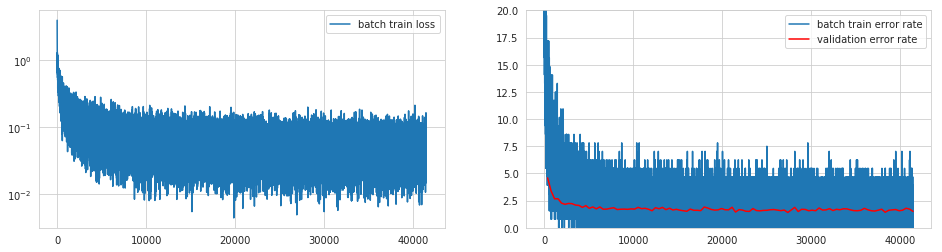

In [363]:
model = FeedforwardNet(
    [
     DropoutLayer(0.2),
     AffineLayer(784, 1000),
     ReLULayer(),
     DropoutLayer(0.5),        
     AffineLayer(1000,1000),
     TanhLayer(),
     DropoutLayer(0.5),
     AffineLayer(1000, 10),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            p.normal_(0, 0.05)
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, device='cpu', alpha_mult=0.012, epsilon=0.5)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

torch.Size([50000, 28, 28])

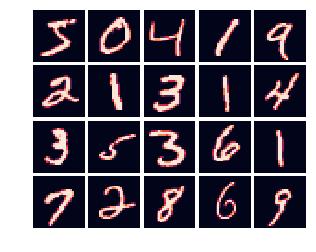

In [278]:

plot_mat(_train.train_data[:20, None].data.numpy())
#28x28 images
_train.train_data.shape


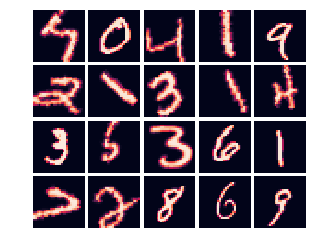

In [23]:
import torchvision as tv

def rand_rotation(imgMatrix, deg=90):
    rnd = tv.transforms.RandomRotation(degrees=deg)
    pil = tv.transforms.ToPILImage()
    tens = tv.transforms.ToTensor()    
    return tens(rnd(pil(imgMatrix))).data

def rand_crop(imgMatrix):
    #list = []
    crop = tv.transforms.RandomResizedCrop(28, scale=(0.3, 1.0))
    pil = tv.transforms.ToPILImage()
    tens = tv.transforms.ToTensor()      
    return tens(crop(pil(imgMatrix))).data    

def rand_gray(imgMatrix):
    gray = tv.transforms.ColorJitter(brightness=1, contrast=1, saturation=0.1)
    pil = tv.transforms.ToPILImage()
    tens = tv.transforms.ToTensor()      
    return tens(gray(pil(imgMatrix))).data      

def rand_effect(imgMatrix):
    transf = tv.transforms.Compose([
        tv.transforms.ToPILImage(),
        tv.transforms.RandomApply([
        tv.transforms.RandomRotation(45),
        tv.transforms.RandomResizedCrop(28, scale=(0.6, 1.0))]),
        #tv.transforms.ColorJitter(brightness=1, contrast=1, saturation=0.1)]),
        tv.transforms.ToTensor()])
    return transf(imgMatrix)


plot_mat (torch.stack([rand_effect(img[None, :, :]) for img in _train.train_data[:20]])[:,-1].numpy()[:,None])


In [364]:
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)

aug_number = 50000

_train.train_data = _train.train_data[:50000]
_train.train_labels = _train.train_labels[:50000]

_rand_data = (255*torch.stack([rand_effect(img[None,:,:]) for img in _train.train_data[:aug_number]])[:,-1]).byte()
_train.train_data = torch.cat((_train.train_data, _rand_data), 0)
_train.train_labels = torch.cat((_train.train_labels, _train.train_labels[:aug_number]), 0)

print _train.train_data.shape, _train.train_labels.shape


mnist_loaders = {
    'train': torch.utils.data.DataLoader(
        _train, batch_size=batch_size, shuffle=True,
        pin_memory=True, num_workers=10),
    'valid': torch.utils.data.DataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(
        _test, batch_size=batch_size, shuffle=False)}


torch.Size([100000, 28, 28]) torch.Size([100000])


# Problem 4: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  1.21 | err rate 35.94%, steps/s 26.14
Minibatch    200  | loss  0.90 | err rate 32.03%, steps/s 58.21
Minibatch    300  | loss  0.68 | err rate 21.09%, steps/s 87.92
Minibatch    400  | loss  0.53 | err rate 12.50%, steps/s 110.40
Minibatch    500  | loss  0.47 | err rate 15.62%, steps/s 141.51
Minibatch    600  | loss  0.69 | err rate 17.97%, steps/s 174.60
Minibatch    700  | loss  0.69 | err rate 25.78%, steps/s 205.75
---------------------------------------------------------------------------
After epoch  1 | valid err rate:  3.66% | doing   2 epochs | alpha 0.100000
---------------------------------------------------------------------------
Minibatch    800  | loss  0.65 | err rate 20.31%, steps/s 162.30
Minibatch    900  | loss  0.50 | err rate 17.19%, steps/s 264.26
Minibatch   1000  | loss  0.63 | err rate 17.19%, steps/s 292.10
Minibatch   1100  | loss  0.28 | err 

Minibatch   8700  | loss  0.29 | err rate  7.81%, steps/s 1682.57
Minibatch   8800  | loss  0.27 | err rate 10.16%, steps/s 2470.67
Minibatch   8900  | loss  0.32 | err rate 10.94%, steps/s 2499.22
Minibatch   9000  | loss  0.34 | err rate  8.59%, steps/s 2510.17
Minibatch   9100  | loss  0.25 | err rate  9.38%, steps/s 2553.72
Minibatch   9200  | loss  0.33 | err rate 10.94%, steps/s 2674.91
Minibatch   9300  | loss  0.37 | err rate 10.16%, steps/s 2563.44
---------------------------------------------------------------------------
After epoch 12 | valid err rate:  1.61% | doing  19 epochs | alpha 0.084935
---------------------------------------------------------------------------
Minibatch   9400  | loss  0.28 | err rate  8.59%, steps/s 1876.20
Minibatch   9500  | loss  0.25 | err rate  9.38%, steps/s 2171.44
Minibatch   9600  | loss  0.31 | err rate  7.03%, steps/s 2566.95
Minibatch   9700  | loss  0.28 | err rate  9.38%, steps/s 2769.22
Minibatch   9800  | loss  0.21 | err rate  7.0

Minibatch  17400  | loss  0.10 | err rate  3.12%, steps/s 4631.31
Minibatch  17500  | loss  0.24 | err rate  8.59%, steps/s 4958.62
Minibatch  17600  | loss  0.11 | err rate  3.12%, steps/s 4992.44
Minibatch  17700  | loss  0.18 | err rate  4.69%, steps/s 4941.83
Minibatch  17800  | loss  0.21 | err rate  5.47%, steps/s 4730.46
Minibatch  17900  | loss  0.31 | err rate  7.81%, steps/s 5053.38
---------------------------------------------------------------------------
After epoch 23 | valid err rate:  1.60% | doing  28 epochs | alpha 0.072139
---------------------------------------------------------------------------
Minibatch  18000  | loss  0.18 | err rate  4.69%, steps/s 3545.67
Minibatch  18100  | loss  0.34 | err rate 12.50%, steps/s 5305.24
Minibatch  18200  | loss  0.21 | err rate  5.47%, steps/s 5319.68
Minibatch  18300  | loss  0.26 | err rate 10.94%, steps/s 4916.91
Minibatch  18400  | loss  0.23 | err rate  7.81%, steps/s 5373.63
Minibatch  18500  | loss  0.24 | err rate  6.2

Minibatch  26100  | loss  0.26 | err rate  8.59%, steps/s 7485.07
Minibatch  26200  | loss  0.14 | err rate  4.69%, steps/s 7686.97
Minibatch  26300  | loss  0.14 | err rate  3.12%, steps/s 7410.67
Minibatch  26400  | loss  0.14 | err rate  3.91%, steps/s 7392.72
Minibatch  26500  | loss  0.20 | err rate  6.25%, steps/s 7470.15
---------------------------------------------------------------------------
After epoch 34 | valid err rate:  1.50% | doing  47 epochs | alpha 0.058820
---------------------------------------------------------------------------
Minibatch  26600  | loss  0.15 | err rate  3.12%, steps/s 5387.59
Minibatch  26700  | loss  0.11 | err rate  2.34%, steps/s 7854.65
Minibatch  26800  | loss  0.10 | err rate  1.56%, steps/s 7270.81
Minibatch  26900  | loss  0.17 | err rate  3.91%, steps/s 7377.83
Minibatch  27000  | loss  0.12 | err rate  3.12%, steps/s 8049.83
Minibatch  27100  | loss  0.22 | err rate  4.69%, steps/s 7732.56
Minibatch  27200  | loss  0.18 | err rate  4.6

Minibatch  34800  | loss  0.15 | err rate  4.69%, steps/s 9982.29
Minibatch  34900  | loss  0.17 | err rate  5.47%, steps/s 9978.79
Minibatch  35000  | loss  0.16 | err rate  3.12%, steps/s 9833.51
Minibatch  35100  | loss  0.14 | err rate  5.47%, steps/s 10091.04
---------------------------------------------------------------------------
After epoch 45 | valid err rate:  1.37% | doing  67 epochs | alpha 0.049959
---------------------------------------------------------------------------
Minibatch  35200  | loss  0.24 | err rate  7.03%, steps/s 7064.41
Minibatch  35300  | loss  0.15 | err rate  4.69%, steps/s 10007.87
Minibatch  35400  | loss  0.19 | err rate  4.69%, steps/s 10132.26
Minibatch  35500  | loss  0.19 | err rate  6.25%, steps/s 9786.49
Minibatch  35600  | loss  0.15 | err rate  5.47%, steps/s 9982.38
Minibatch  35700  | loss  0.27 | err rate  7.81%, steps/s 10531.38
Minibatch  35800  | loss  0.15 | err rate  3.12%, steps/s 9988.04
Minibatch  35900  | loss  0.22 | err rate 

Minibatch  43400  | loss  0.14 | err rate  2.34%, steps/s 12149.89
Minibatch  43500  | loss  0.21 | err rate  7.03%, steps/s 12491.86
Minibatch  43600  | loss  0.16 | err rate  7.03%, steps/s 12757.65
Minibatch  43700  | loss  0.17 | err rate  5.47%, steps/s 12648.19
---------------------------------------------------------------------------
After epoch 56 | valid err rate:  1.35% | doing  67 epochs | alpha 0.042432
---------------------------------------------------------------------------
Minibatch  43800  | loss  0.18 | err rate  6.25%, steps/s 8699.75
Minibatch  43900  | loss  0.28 | err rate 10.16%, steps/s 12587.89
Minibatch  44000  | loss  0.18 | err rate  6.25%, steps/s 12613.91
Minibatch  44100  | loss  0.18 | err rate  4.69%, steps/s 12372.27
Minibatch  44200  | loss  0.13 | err rate  4.69%, steps/s 12878.45
Minibatch  44300  | loss  0.14 | err rate  4.69%, steps/s 12447.58
Minibatch  44400  | loss  0.10 | err rate  2.34%, steps/s 12726.32
Minibatch  44500  | loss  0.16 | err

Minibatch  51900  | loss  0.10 | err rate  3.91%, steps/s 14728.11
Minibatch  52000  | loss  0.15 | err rate  4.69%, steps/s 14623.92
Minibatch  52100  | loss  0.33 | err rate  8.59%, steps/s 14989.18
Minibatch  52200  | loss  0.18 | err rate  3.12%, steps/s 14368.77
Minibatch  52300  | loss  0.23 | err rate  7.03%, steps/s 14726.51
---------------------------------------------------------------------------
After epoch 67 | valid err rate:  1.35% | doing  97 epochs | alpha 0.034598
---------------------------------------------------------------------------
Minibatch  52400  | loss  0.27 | err rate  8.59%, steps/s 10323.37
Minibatch  52500  | loss  0.14 | err rate  3.91%, steps/s 15332.09
Minibatch  52600  | loss  0.21 | err rate  7.03%, steps/s 15500.90
Minibatch  52700  | loss  0.18 | err rate  6.25%, steps/s 15134.40
Minibatch  52800  | loss  0.12 | err rate  2.34%, steps/s 15028.94
Minibatch  52900  | loss  0.10 | err rate  0.78%, steps/s 14888.97
Minibatch  53000  | loss  0.16 | er

Minibatch  60400  | loss  0.16 | err rate  3.12%, steps/s 17317.29
Minibatch  60500  | loss  0.14 | err rate  3.91%, steps/s 17064.87
Minibatch  60600  | loss  0.09 | err rate  1.56%, steps/s 17831.66
Minibatch  60700  | loss  0.22 | err rate  7.81%, steps/s 17145.54
Minibatch  60800  | loss  0.14 | err rate  4.69%, steps/s 17477.27
Minibatch  60900  | loss  0.13 | err rate  2.34%, steps/s 17616.61
---------------------------------------------------------------------------
After epoch 78 | valid err rate:  1.29% | doing 106 epochs | alpha 0.029386
---------------------------------------------------------------------------
Minibatch  61000  | loss  0.23 | err rate  7.03%, steps/s 12611.66
Minibatch  61100  | loss  0.08 | err rate  0.78%, steps/s 17257.79
Minibatch  61200  | loss  0.13 | err rate  3.12%, steps/s 18194.14
Minibatch  61300  | loss  0.16 | err rate  3.12%, steps/s 18287.93
Minibatch  61400  | loss  0.13 | err rate  4.69%, steps/s 18143.23
Minibatch  61500  | loss  0.19 | er

Minibatch  68900  | loss  0.15 | err rate  3.12%, steps/s 14105.67
Minibatch  69000  | loss  0.17 | err rate  6.25%, steps/s 19931.35
Minibatch  69100  | loss  0.19 | err rate  7.03%, steps/s 20320.08
Minibatch  69200  | loss  0.19 | err rate  7.03%, steps/s 20012.55
Minibatch  69300  | loss  0.09 | err rate  3.12%, steps/s 19846.90
Minibatch  69400  | loss  0.13 | err rate  4.69%, steps/s 19981.83
Minibatch  69500  | loss  0.15 | err rate  5.47%, steps/s 19949.85
---------------------------------------------------------------------------
After epoch 89 | valid err rate:  1.29% | doing 130 epochs | alpha 0.024959
---------------------------------------------------------------------------
Minibatch  69600  | loss  0.23 | err rate  6.25%, steps/s 14489.66
Minibatch  69700  | loss  0.07 | err rate  1.56%, steps/s 20576.00
Minibatch  69800  | loss  0.12 | err rate  3.12%, steps/s 20174.42
Minibatch  69900  | loss  0.18 | err rate  3.91%, steps/s 20616.94
Minibatch  70000  | loss  0.16 | er

Minibatch  77500  | loss  0.13 | err rate  3.91%, steps/s 15842.58
Minibatch  77600  | loss  0.08 | err rate  0.78%, steps/s 22735.34
Minibatch  77700  | loss  0.13 | err rate  4.69%, steps/s 22130.48
Minibatch  77800  | loss  0.16 | err rate  3.91%, steps/s 23224.43
Minibatch  77900  | loss  0.14 | err rate  3.91%, steps/s 23177.21
Minibatch  78000  | loss  0.10 | err rate  3.91%, steps/s 22566.00
Minibatch  78100  | loss  0.14 | err rate  3.91%, steps/s 22567.48
Minibatch  78200  | loss  0.06 | err rate  0.00%, steps/s 24368.28
----------------------------------------------------------------------------
After epoch 100 | valid err rate:  1.21% | doing 130 epochs | alpha 0.020351
----------------------------------------------------------------------------
Minibatch  78300  | loss  0.13 | err rate  3.91%, steps/s 15606.36
Minibatch  78400  | loss  0.15 | err rate  3.12%, steps/s 23015.88
Minibatch  78500  | loss  0.14 | err rate  3.91%, steps/s 22151.76
Minibatch  78600  | loss  0.24 |

Minibatch  86100  | loss  0.13 | err rate  4.69%, steps/s 17775.44
Minibatch  86200  | loss  0.21 | err rate  7.03%, steps/s 25083.63
Minibatch  86300  | loss  0.12 | err rate  2.34%, steps/s 24957.92
Minibatch  86400  | loss  0.20 | err rate  4.69%, steps/s 24438.27
Minibatch  86500  | loss  0.19 | err rate  7.03%, steps/s 24996.25
Minibatch  86600  | loss  0.13 | err rate  4.69%, steps/s 25521.53
Minibatch  86700  | loss  0.13 | err rate  3.12%, steps/s 25052.52
Minibatch  86800  | loss  0.14 | err rate  4.69%, steps/s 26704.83
----------------------------------------------------------------------------
After epoch 111 | valid err rate:  1.24% | doing 130 epochs | alpha 0.017285
----------------------------------------------------------------------------
Minibatch  86900  | loss  0.14 | err rate  4.69%, steps/s 17386.18
Minibatch  87000  | loss  0.26 | err rate  6.25%, steps/s 25097.32
Minibatch  87100  | loss  0.13 | err rate  3.91%, steps/s 24658.11
Minibatch  87200  | loss  0.17 |

Minibatch  94700  | loss  0.08 | err rate  3.12%, steps/s 19122.93
Minibatch  94800  | loss  0.20 | err rate  6.25%, steps/s 27474.87
Minibatch  94900  | loss  0.21 | err rate  8.59%, steps/s 27699.70
Minibatch  95000  | loss  0.08 | err rate  3.12%, steps/s 26851.14
Minibatch  95100  | loss  0.19 | err rate  5.47%, steps/s 27307.50
Minibatch  95200  | loss  0.13 | err rate  3.12%, steps/s 27458.66
Minibatch  95300  | loss  0.17 | err rate  5.47%, steps/s 28315.37
Minibatch  95400  | loss  0.13 | err rate  1.56%, steps/s 28772.62
----------------------------------------------------------------------------
After epoch 122 | valid err rate:  1.24% | doing 182 epochs | alpha 0.014681
----------------------------------------------------------------------------
Minibatch  95500  | loss  0.17 | err rate  4.69%, steps/s 19113.89
Minibatch  95600  | loss  0.17 | err rate  6.25%, steps/s 28312.05
Minibatch  95700  | loss  0.15 | err rate  5.47%, steps/s 27710.02
Minibatch  95800  | loss  0.17 |

Minibatch 103300  | loss  0.09 | err rate  0.78%, steps/s 21507.58
Minibatch 103400  | loss  0.24 | err rate  7.03%, steps/s 30529.70
Minibatch 103500  | loss  0.17 | err rate  5.47%, steps/s 29774.72
Minibatch 103600  | loss  0.15 | err rate  3.91%, steps/s 30619.10
Minibatch 103700  | loss  0.16 | err rate  4.69%, steps/s 30101.47
Minibatch 103800  | loss  0.10 | err rate  2.34%, steps/s 30711.63
Minibatch 103900  | loss  0.12 | err rate  4.69%, steps/s 29782.09
Minibatch 104000  | loss  0.12 | err rate  1.56%, steps/s 30008.41
----------------------------------------------------------------------------
After epoch 133 | valid err rate:  1.25% | doing 182 epochs | alpha 0.011970
----------------------------------------------------------------------------
Minibatch 104100  | loss  0.07 | err rate  0.78%, steps/s 20866.18
Minibatch 104200  | loss  0.14 | err rate  3.12%, steps/s 30921.69
Minibatch 104300  | loss  0.14 | err rate  3.91%, steps/s 29976.87
Minibatch 104400  | loss  0.08 |

Minibatch 111900  | loss  0.16 | err rate  3.91%, steps/s 23150.27
Minibatch 112000  | loss  0.11 | err rate  4.69%, steps/s 32952.09
Minibatch 112100  | loss  0.09 | err rate  1.56%, steps/s 32131.18
Minibatch 112200  | loss  0.11 | err rate  3.12%, steps/s 32845.52
Minibatch 112300  | loss  0.19 | err rate  5.47%, steps/s 32113.53
Minibatch 112400  | loss  0.08 | err rate  1.56%, steps/s 32821.73
Minibatch 112500  | loss  0.12 | err rate  0.78%, steps/s 33019.15
Minibatch 112600  | loss  0.18 | err rate  5.47%, steps/s 32192.17
----------------------------------------------------------------------------
After epoch 144 | valid err rate:  1.15% | doing 208 epochs | alpha 0.010167
----------------------------------------------------------------------------
Minibatch 112700  | loss  0.18 | err rate  4.69%, steps/s 22260.04
Minibatch 112800  | loss  0.13 | err rate  3.12%, steps/s 33614.78
Minibatch 112900  | loss  0.18 | err rate  5.47%, steps/s 33428.63
Minibatch 113000  | loss  0.13 |

Minibatch 120500  | loss  0.09 | err rate  2.34%, steps/s 24630.21
Minibatch 120600  | loss  0.16 | err rate  4.69%, steps/s 34808.95
Minibatch 120700  | loss  0.14 | err rate  2.34%, steps/s 33999.74
Minibatch 120800  | loss  0.14 | err rate  4.69%, steps/s 34692.54
Minibatch 120900  | loss  0.14 | err rate  3.91%, steps/s 34063.23
Minibatch 121000  | loss  0.15 | err rate  5.47%, steps/s 34706.33
Minibatch 121100  | loss  0.12 | err rate  1.56%, steps/s 35856.66
Minibatch 121200  | loss  0.10 | err rate  3.12%, steps/s 36776.59
----------------------------------------------------------------------------
After epoch 155 | valid err rate:  1.12% | doing 208 epochs | alpha 0.008635
----------------------------------------------------------------------------
Minibatch 121300  | loss  0.09 | err rate  3.12%, steps/s 24372.34
Minibatch 121400  | loss  0.18 | err rate  5.47%, steps/s 35044.16
Minibatch 121500  | loss  0.13 | err rate  4.69%, steps/s 34715.73
Minibatch 121600  | loss  0.17 |

Minibatch 129100  | loss  0.08 | err rate  0.78%, steps/s 26359.04
Minibatch 129200  | loss  0.13 | err rate  2.34%, steps/s 36595.69
Minibatch 129300  | loss  0.06 | err rate  1.56%, steps/s 38569.28
Minibatch 129400  | loss  0.19 | err rate  5.47%, steps/s 37543.61
Minibatch 129500  | loss  0.12 | err rate  3.12%, steps/s 38315.61
Minibatch 129600  | loss  0.21 | err rate  7.81%, steps/s 37667.73
Minibatch 129700  | loss  0.15 | err rate  3.12%, steps/s 37382.56
Minibatch 129800  | loss  0.16 | err rate  6.25%, steps/s 38133.04
----------------------------------------------------------------------------
After epoch 166 | valid err rate:  1.14% | doing 208 epochs | alpha 0.007334
----------------------------------------------------------------------------
Minibatch 129900  | loss  0.12 | err rate  4.69%, steps/s 26607.68
Minibatch 130000  | loss  0.21 | err rate  6.25%, steps/s 38377.79
Minibatch 130100  | loss  0.14 | err rate  4.69%, steps/s 38342.99
Minibatch 130200  | loss  0.17 |

Minibatch 137700  | loss  0.08 | err rate  0.78%, steps/s 28611.59
Minibatch 137800  | loss  0.19 | err rate  6.25%, steps/s 38779.57
Minibatch 137900  | loss  0.18 | err rate  5.47%, steps/s 39544.64
Minibatch 138000  | loss  0.13 | err rate  5.47%, steps/s 40947.09
Minibatch 138100  | loss  0.08 | err rate  3.12%, steps/s 39792.42
Minibatch 138200  | loss  0.19 | err rate  4.69%, steps/s 40954.85
Minibatch 138300  | loss  0.15 | err rate  3.12%, steps/s 40994.62
Minibatch 138400  | loss  0.19 | err rate  7.03%, steps/s 39520.17
----------------------------------------------------------------------------
After epoch 177 | valid err rate:  1.07% | doing 208 epochs | alpha 0.005980
----------------------------------------------------------------------------
Minibatch 138500  | loss  0.08 | err rate  2.34%, steps/s 27672.72
Minibatch 138600  | loss  0.12 | err rate  2.34%, steps/s 41001.41
Minibatch 138700  | loss  0.17 | err rate  6.25%, steps/s 40956.72
Minibatch 138800  | loss  0.19 |

Minibatch 146300  | loss  0.14 | err rate  2.34%, steps/s 30295.64
Minibatch 146400  | loss  0.10 | err rate  2.34%, steps/s 43503.97
Minibatch 146500  | loss  0.08 | err rate  1.56%, steps/s 41664.28
Minibatch 146600  | loss  0.15 | err rate  4.69%, steps/s 43565.00
Minibatch 146700  | loss  0.12 | err rate  3.12%, steps/s 43676.23
Minibatch 146800  | loss  0.15 | err rate  3.91%, steps/s 43325.86
Minibatch 146900  | loss  0.16 | err rate  3.91%, steps/s 42762.23
Minibatch 147000  | loss  0.19 | err rate  6.25%, steps/s 42932.72
----------------------------------------------------------------------------
After epoch 188 | valid err rate:  1.18% | doing 208 epochs | alpha 0.005079
----------------------------------------------------------------------------
Minibatch 147100  | loss  0.21 | err rate  5.47%, steps/s 30405.37
Minibatch 147200  | loss  0.09 | err rate  3.12%, steps/s 43522.11
Minibatch 147300  | loss  0.11 | err rate  2.34%, steps/s 43537.63
Minibatch 147400  | loss  0.13 |

Minibatch 154900  | loss  0.16 | err rate  3.91%, steps/s 31825.60
Minibatch 155000  | loss  0.09 | err rate  1.56%, steps/s 46456.53
Minibatch 155100  | loss  0.17 | err rate  7.03%, steps/s 44487.19
Minibatch 155200  | loss  0.13 | err rate  4.69%, steps/s 44045.93
Minibatch 155300  | loss  0.13 | err rate  3.12%, steps/s 46211.22
Minibatch 155400  | loss  0.07 | err rate  2.34%, steps/s 42951.52
Minibatch 155500  | loss  0.11 | err rate  3.12%, steps/s 46470.09
Minibatch 155600  | loss  0.12 | err rate  4.69%, steps/s 44432.25
----------------------------------------------------------------------------
After epoch 199 | valid err rate:  1.12% | doing 208 epochs | alpha 0.004314
----------------------------------------------------------------------------
Minibatch 155700  | loss  0.11 | err rate  1.56%, steps/s 31623.41
Minibatch 155800  | loss  0.10 | err rate  2.34%, steps/s 45159.78
Minibatch 155900  | loss  0.16 | err rate  5.47%, steps/s 45066.01
Minibatch 156000  | loss  0.13 |

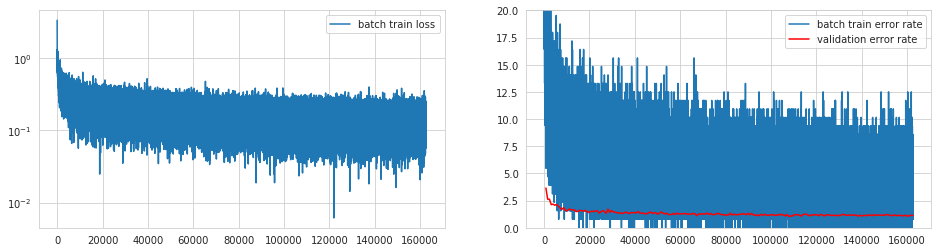

In [366]:
model = FeedforwardNet(
    [
     DropoutLayer(0.2),
     AffineLayer(784, 1000),
     ReLULayer(),
     DropoutLayer(0.4),        
     AffineLayer(1000,1000),
     TanhLayer(),
     DropoutLayer(0.4),
     AffineLayer(1000, 10),
     SoftMaxLayer()
    ])


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            p.normal_(0, 0.05)
            # p.data.uniform_(-0.1, 0.1)
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, device='cpu', alpha_mult=0.04, epsilon=0.30)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

# Problem 5: Batch Normalization [1p]

*Covariate shift* is a phenomenon associated with training deep models. Simply put, weight changes in early layers cause major changes in distribution of inputs to later layers, making it difficult to train later layers.

[Batch Normalization](https://arxiv.org/abs/1502.03167) addresses this problem by normalizing distributions of inputs to layers within mini-batches. It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

# Problem 6: Norm Constraints [1p bonus]

Implement norm constraints, i.e. instead of weight decay, that tries to set 
all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

# Problem 6: Polyak Averaging [1p bonus]

Implement Polyak averaging. For each parameter $\theta$
keep a separate, exponentially decayed average of the past values
$$
\bar{\theta}_n = \alpha_p\bar{\theta}_{n-1} + (1-\alpha_p)\theta_n.
$$
Use that average when evaluating the model on the test set.
Validate the approach by training a model on the MNIST dataset.

# Problem 7: Convolutional Network [2p bonus]

Use convolutional and max-pooling layers (`torch.nn.functional.conv2d`, `torch.nn.functional.max_pool2d`) and (without dropout) get a test error rate below 1.5%.

# Problem 8: Hyperparameter tuner [1p bonus]

Implement a hyper-parameter tuner able to optimize the learing rate schedule, number of neurons and similar hyperparameters. For start, use random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.